In [5]:
cd ..

/Users/lisawink/Documents/freiburg


In [19]:
import geopandas as gpd
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import calc_params
import altair as alt
from mpl_toolkits.mplot3d import Axes3D
alt.data_transformers.enable("vegafusion")
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import warnings

warnings.filterwarnings('ignore')

In [7]:
temp =  pd.read_csv('/Users/lisawink/Documents/paper1/data/gap_filled_data_ta_rh.csv')
temp['datetime_UTC']=pd.to_datetime(temp['datetime_UTC'])
temp = temp[temp['variable']=='Ta_deg_C']
temp['datetime_UTC'] = temp['datetime_UTC'].astype(str)
temp = temp.pivot(index='station_id', columns='datetime_UTC', values='value')

In [8]:
hiwn = pd.read_csv('/Users/lisawink/Documents/paper1/data/processed_data/heat_island_winter_nights.csv')

In [9]:
# Define station IDs
stations = ['FRASHA', 'FRBETZ', 'FRBRUH', 'FRDREI', 'FRFRIE', 'FRGART', 'FRGLBA',
            'FRGUNT', 'FRHAID', 'FRHBHF', 'FRHERD', 'FRHOLZ', 'FRIHOC', 'FRINST',
            'FRKART', 'FRLAND', 'FRLORE', 'FRMESS', 'FROWIE', 'FRPDAS', 'FRRIES',
            'FRSEEP', 'FRSTGA', 'FRSTGE', 'FRSTUH', 'FRUNIK', 'FRUWIE', 'FRVAUB',
            'FRWEIN', 'FRWSEE', 'FRZAHR']

# Create a colormap (e.g., using the 'tab20' color palette)
cmap = plt.get_cmap('tab20', len(stations))  # 31 unique colors
station_colors = {station: cmap(i) for i, station in enumerate(stations)}  # Map station to color


In [32]:
def stats_multiple_times(radius, var, time):
    vars = gpd.read_parquet(f'/Users/lisawink/Documents/paper1/data/processed_data/processed_station_params_{radius}.parquet')
    vars.index = vars['station_id']
    to_remove = ['station_id','station_no','station_name','station_long_name','station_type','station_lat','station_lon','station_elevation','mounting_structure','sky_view_factor','dominant_land_use','local_climate_zone','urban_atlas_class','urban_atlas_code','geometry','SVF']
    vars = vars.drop(to_remove, axis=1)
    vars = vars.merge(temp, left_on='station_id', right_on='station_id',how='inner')

    scaler = StandardScaler()
    vars_scaled = scaler.fit_transform(vars)
    vars = pd.DataFrame(vars_scaled, columns=vars.columns, index=vars.index)

    vars['BuSqC_wmean'] = -vars['BuSqC_wmean']
    vars['BuFra_3D_wmean'] = -vars['BuFra_3D_wmean']
    vars['BuIBD'] = -vars['BuIBD']
    vars['BuAdj'] = -vars['BuAdj']

    data = vars[[var] + list(hiwn.values.flatten())].copy().reset_index()
    data = data.melt(id_vars=[var,'station_id'], value_vars=hiwn.values.flatten(), var_name='time', value_name='temperature')
    data = data.dropna()

    # Compute Spearman correlation
    spearman_corr, p_value = spearmanr(data[var], data['temperature'])

    #Pearson and r squared
    pearson_corr, _ = pearsonr(data[var], data['temperature'])
    X = sm.add_constant(data[var])  # Add constant for regression
    model = sm.OLS(data['temperature'], X).fit()
    r_squared = model.rsquared

    # Get the predicted values (fitted values)
    y_pred = model.fittedvalues

    # Calculate the residuals (errors)
    residuals = data['temperature'] - y_pred

    # Calculate the least squares error (RSS)
    rss = np.sum(residuals ** 2)
    # Calculate the Mean Squared Error (MSE)
    mse = rss / len(data[var])
    # Calculate the Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Compute Cook's distance
    influence = model.get_influence()
    cooks_d = influence.cooks_distance[0].max()  # Max Cook's distance

    return data, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred

In [11]:
var = 'StrHW_median'

/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/skle

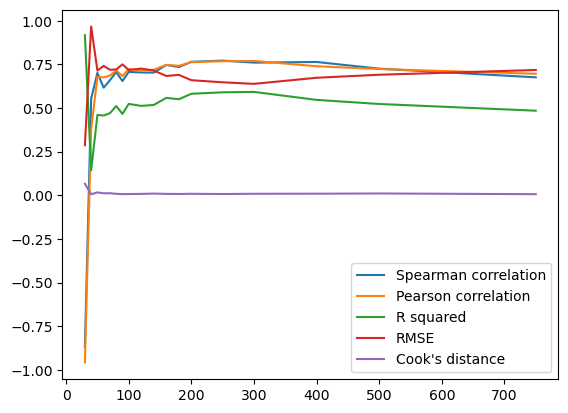

In [14]:
radii = [30,40,50,60,70,80,90,100,120,140,160,180,200,250,300,400,500,750]
mean_stats = {}

for radius in radii:
    data, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred = stats_multiple_times(radius, var, hiwn)
    mean_stats[radius] = {'spearman_corr': spearman_corr, 'p_value': p_value, 'pearson_corr': pearson_corr, 'r_squared': r_squared, 'rmse': rmse, 'cooks_d': cooks_d}

mean_stats = pd.DataFrame(mean_stats).T
plt.plot(radii, mean_stats['spearman_corr'], label='Spearman correlation')
plt.plot(radii, mean_stats['pearson_corr'], label='Pearson correlation')
plt.plot(radii, mean_stats['r_squared'], label='R squared')
plt.plot(radii, mean_stats['rmse'], label='RMSE')
plt.plot(radii, mean_stats['cooks_d'], label="Cook's distance")
plt.legend()

In [19]:
def param_scale_plot(var):

    radii = [30,40,50,60,70,80,90,100,120,140,160,180,200,250,300,400,500,750]
    mean_stats = {}

    for radius in radii:
        data, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred = stats_multiple_times(radius, var, hiwn)
        mean_stats[radius] = {'spearman_corr': spearman_corr, 'p_value': p_value, 'pearson_corr': pearson_corr, 'r_squared': r_squared, 'rmse': rmse, 'cooks_d': cooks_d}

    fig = go.Figure()

    mean_stats = pd.DataFrame(mean_stats).T

    fig.add_trace(go.Scatter(x=radii, y=mean_stats['spearman_corr'], mode='lines', name='Spearman correlation'))
    fig.add_trace(go.Scatter(x=radii, y=mean_stats['pearson_corr'], mode='lines', name='Pearson correlation'))
    fig.add_trace(go.Scatter(x=radii, y=mean_stats['r_squared'], mode='lines', name='R squared'))
    fig.add_trace(go.Scatter(x=radii, y=mean_stats['rmse'], mode='lines', name='RMSE'))
    fig.add_trace(go.Scatter(x=radii, y=mean_stats['cooks_d'], mode='lines', name="Cook's distance"))

    fig.update_layout(title=var+' correlation and regression statistics across radii',
                        xaxis_title='Radius (m)',
                        yaxis_title='Value')
    fig.show()

In [23]:
def multiple_scales(vars):

    radii = [30,40,50,60,70,80,90,100,120,140,160,180,200,250,300,400,500,750]
    spearman_stats = {}
    p_value_stats = {}
    pearson_stats = {}
    rmse_stats = {}
    cooks_stats = {}
    for radius in radii:
        for var in vars:
            data, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred = stats_multiple_times(radius, var, hiwn)
            spearman_stats[radius].update({var: spearman_corr})
            p_value_stats[radius].update({var: p_value})
            pearson_stats[radius].update({var: pearson_corr})
            rmse_stats[radius].update({var: rmse})
            cooks_stats[radius].update({var: cooks_d})
    return spearman_stats, p_value_stats, pearson_stats, rmse_stats, cooks_stats


In [25]:
def multiple_scales(vars):

    radii = [30,40,50,60,70,80,90,100,120,140,160,180,200,250,300,400,500,750]
    spearman_stats = {}
    p_value_stats = {}
    pearson_stats = {}
    rmse_stats = {}
    cooks_stats = {}
    
    for radius in radii:
        spearman_stats[radius] = {}
        p_value_stats[radius] = {}
        pearson_stats[radius] = {}
        rmse_stats[radius] = {}
        cooks_stats[radius] = {}
        
        for var in vars:
            data, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred = stats_multiple_times(radius, var, hiwn)
            spearman_stats[radius][var] = spearman_corr
            p_value_stats[radius][var] = p_value
            pearson_stats[radius][var] = pearson_corr
            rmse_stats[radius][var] = rmse
            cooks_stats[radius][var] = cooks_d
            
    return spearman_stats, p_value_stats, pearson_stats, rmse_stats, cooks_stats

In [16]:
params = ['BuAre_sum', 'BuVol_3D_sum', 'BuSA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','BuOri_mean', 'BuSqC_wmean','BuFra_3D_wmean', 'StrClo400_median']

In [33]:
spearman_stats, p_value_stats, pearson_stats, rmse_stats, cooks_stats = multiple_scales(params)

In [34]:
spearman_stats = pd.DataFrame(spearman_stats).T
p_value_stats = pd.DataFrame(p_value_stats).T
pearson_stats = pd.DataFrame(pearson_stats).T
rmse_stats = pd.DataFrame(rmse_stats).T
cooks_stats = pd.DataFrame(cooks_stats).T

In [56]:
spearman_stats

,BuAre_sum,BuVol_3D_sum,BuSA_3D_sum,BuIBD,BuAdj,BuSWR_3D_median,BuHt_wmean,StrHW_median,BuOri_mean,BuSqC_wmean,BuFra_3D_wmean,StrClo400_median
30,0.510881,0.542349,0.575249,0.422304,0.059203,0.114346,0.571457,-0.866040,-0.008114,0.324540,0.540196,0.916913
40,0.245129,0.539944,0.214053,0.216809,0.160270,0.168067,0.519599,0.553231,0.014257,0.352874,0.536594,0.862203
50,0.172776,0.354211,0.233630,0.143260,0.118813,0.357876,0.445880,0.701307,0.165544,0.442404,0.462899,0.577787
60,0.123611,0.363871,0.312545,0.219644,0.106935,0.487082,0.514775,0.616468,0.181358,0.603432,0.546943,0.556865
70,0.170415,0.443550,0.336449,0.424986,0.321839,0.523879,0.627303,0.659270,0.138090,0.645211,0.546278,0.546385
80,0.202515,0.477642,0.406566,0.231431,0.357554,0.543167,0.634968,0.705507,0.125226,0.415751,0.475238,0.545422
90,0.175673,0.410747,0.369861,0.154709,0.514140,0.569238,0.606256,0.654379,0.177410,0.390180,0.429206,0.542266
100,0.286920,0.499218,0.447650,0.236501,0.559056,0.559165,0.611170,0.706549,0.184674,0.407311,0.473477,0.535202
120,0.278775,0.471535,0.460305,0.240778,0.620756,0.592720,0.596359,0.703536,0.187151,0.455669,0.467924,0.383680
140,0.355630,0.524443,0.492384,0.306872,0.592470,0.590205,0.673260,0.702774,0.182674,0.470202,0.519493,0.384760


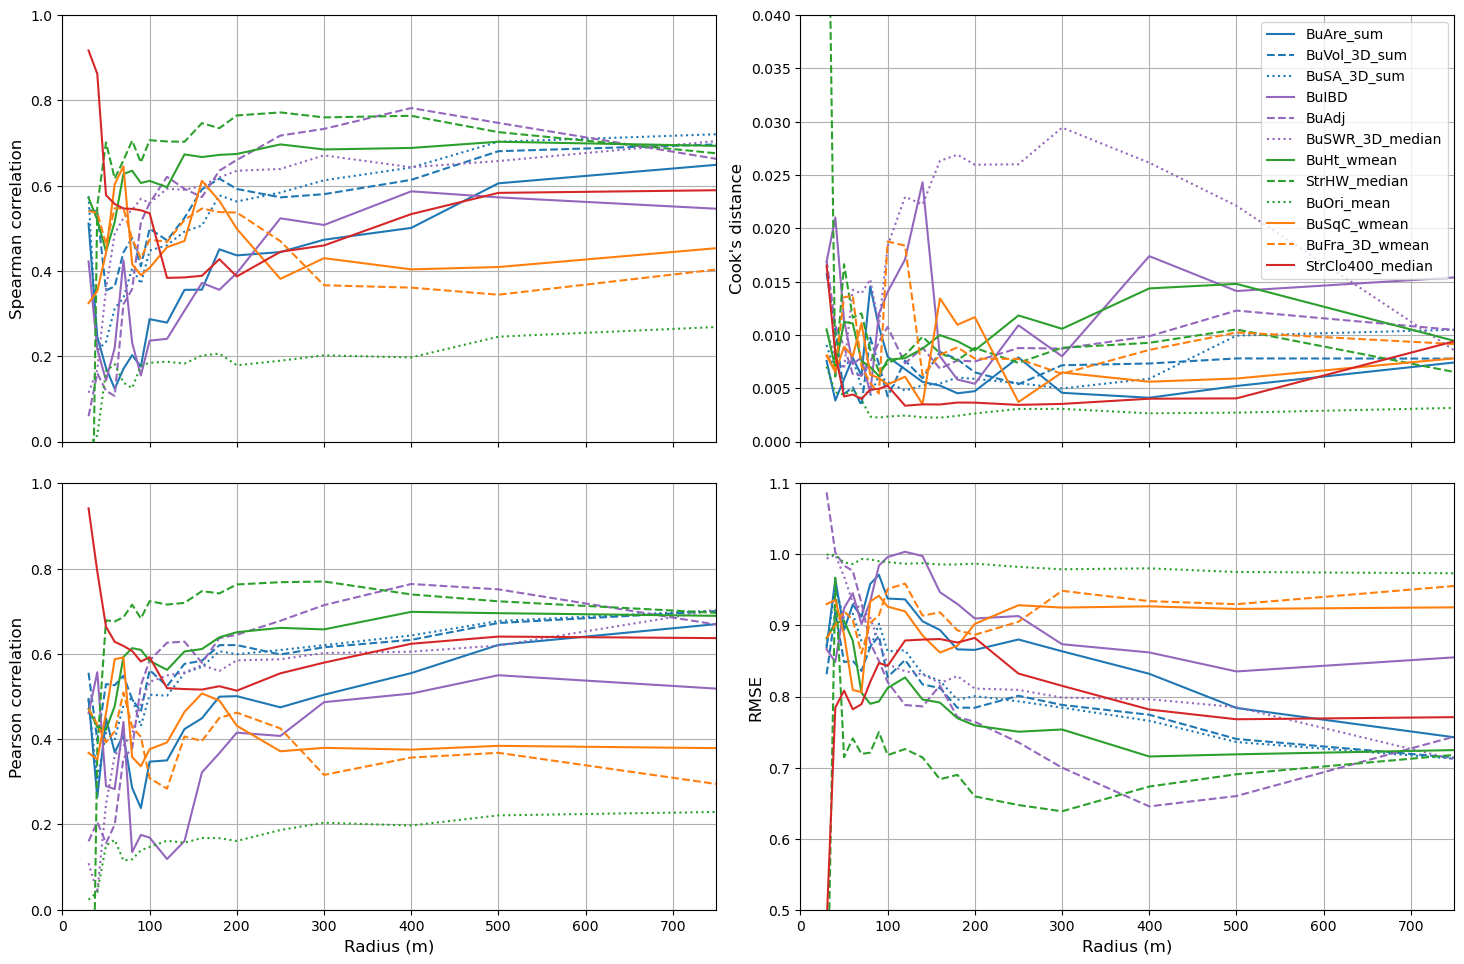

In [74]:
# make 4 subplots
fig, axs = plt.subplots(2,2, figsize=(15, 10))

linestyle_mapping = {
    'BuAre_sum': '-',
    'BuVol_3D_sum': '--',
    'BuSA_3D_sum': ':',
    'BuIBD':'-',
    'BuAdj':'--',
    'BuSWR_3D_median':':',
    'BuHt_wmean': '-',
    'StrHW_median': '--',
    'BuOri_mean': ':',
    'BuSqC_wmean': '-',
    'BuFra_3D_wmean': '--',
    'StrClo400_median': '-'
}

color_mapping = {
    'BuAre_sum': 'tab:blue',
    'BuVol_3D_sum': 'tab:blue',
    'BuSA_3D_sum': 'tab:blue',
    'BuIBD':'tab:purple',
    'BuAdj':'tab:purple',
    'BuSWR_3D_median':'tab:purple',
    'BuHt_wmean': 'tab:green',
    'StrHW_median': 'tab:green',
    'BuOri_mean': 'tab:green',
    'BuSqC_wmean': 'tab:orange',
    'BuFra_3D_wmean': 'tab:orange',
    'StrClo400_median': 'tab:red'
}

for param in params:
    axs[0, 0].plot(spearman_stats[param], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[0, 0].set_ylabel('Spearman correlation', fontsize=12)
axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_xlim(0, 750)
axs[0, 0].set_xticklabels([])
axs[0, 0].grid()

for param in params:
    axs[0, 1].plot(cooks_stats[param], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[0, 1].set_ylabel("Cook's distance", fontsize=12)
axs[0, 1].legend()
axs[0, 1].set_ylim(0, 0.04)
axs[0, 1].set_xlim(0, 750)
axs[0, 1].set_xticklabels([])
axs[0, 1].grid()

for param in params:
    axs[1, 0].plot(pearson_stats[param], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[1, 0].set_ylabel('Pearson correlation', fontsize=12)
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_xlim(0, 750)
axs[1, 0].set_xlabel('Radius (m)', fontsize=12)
axs[1, 0].grid()

for param in params:
    axs[1, 1].plot(rmse_stats[param], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[1, 1].set_ylabel('RMSE', fontsize=12)
axs[1, 1].grid()
axs[1, 1].set_ylim(0.5, 1.1)
axs[1, 1].set_xlim(0, 750)
axs[1, 1].set_xlabel('Radius (m)', fontsize=12)

plt.tight_layout(pad = 2, w_pad=1)
plt.savefig('/Users/lisawink/Documents/paper1/figures/param_scale_plot_featured_list.png')
plt.show()

In [36]:
def plot_scales(vars):

    spearman_stats, p_value_stats, pearson_stats, rmse_stats, cooks_stats = multiple_scales(vars)

    spearman_stats = pd.DataFrame(spearman_stats).T
    p_value_stats = pd.DataFrame(p_value_stats).T
    pearson_stats = pd.DataFrame(pearson_stats).T
    rmse_stats = pd.DataFrame(rmse_stats).T
    cooks_stats = pd.DataFrame(cooks_stats).T

    # make 4 subplots
    fig, axs = plt.subplots(2,2, figsize=(10, 15))

    axs[0, 0].plot(spearman_stats)
    axs[0, 0].set_title('Spearman correlation')
    axs[0, 0].legend(vars)

    axs[0, 1].plot(pearson_stats)
    axs[0, 1].set_title('Pearson correlation')
    axs[0, 1].legend(vars)

    axs[1, 0].plot(rmse_stats)
    axs[1, 0].set_title('RMSE')
    axs[1, 0].legend(vars)

    axs[1, 1].plot(cooks_stats)
    axs[1, 1].set_title("Cook's distance")
    axs[1, 1].legend(vars)

    plt.show()

In [18]:
import warnings

warnings.filterwarnings('ignore')

In [21]:
param_scale_plot('BuAre_sum')

In [22]:
param_scale_plot('BuVol_3D_sum')

In [24]:
param_scale_plot('BuSA_3D_sum')

In [25]:
param_scale_plot('BuIBD')

In [26]:
param_scale_plot('BuAdj')

In [27]:
param_scale_plot('BuSWR_3D_sum')

In [28]:
param_scale_plot('BuHt_wmean')

In [29]:
param_scale_plot('StrHW_median')

In [30]:
param_scale_plot('BuOri_mean')

In [31]:
param_scale_plot('BuSqC_wmean')

In [32]:
param_scale_plot('BuFra_3D_wmean')

In [33]:
param_scale_plot('StrClo400_median')

put all spearman correlation in one plot, colour by type, use dashed lines and what not